In [230]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json
import pickle
import copy
import networkx as nx
from tqdm import tqdm
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs

from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class
from measures0_to_2 import AllMeasures


from expbasics.visualizations import sum_it, data_iterations, my_plot_grid

%reload_ext autoreload
%autoreload 2

In [243]:
128*10*2

2560

In [229]:
ALL_MEASURES = [
    "m0_rho",
    "m0_mi",
    "m0_phi",
    "m1_mi",
    "m1_phi",
    "m1_mlc_abs",
    "m1_mlc_euclid",
    "m1_mlc_cosine",
    "m2_rel_abs",
    "m2_rel_euclid",
    "m2_rel_cosine",
    "m2_mac_abs",
    "m2_mac_euclid",
    "m2_mac_cosine",
    "m2_mac_kernel",
    "m2_rma_sum",
    "m2_rma_weighted",
    "m2_pg_sum",
    "m2_pg_weighted",
    "m2_rra_sum",
    "m2_rra_weighted",
    "m2_bbox_rel",
]
enums = [
    (0, "m0_rho", 1),
    (1, "m0_mi", 1),
    (2, "m0_phi", 1),
    (3, "m1_mi", 1),
    (4, "m1_phi", 1),
    (5, "m1_mlc_abs", 1),
    (6, "m1_mlc_euclid", 256),
    (7, "m1_mlc_cosine", 1),
    (8, "m2_rel_abs", 1),
    (9, "m2_rel_euclid", 16),
    (10, "m2_rel_cosine", 1),
    (11, "m2_mac_abs", 2304),
    (12, "m2_mac_euclid", 16),
    (13, "m2_mac_cosine", 1),
    (14, "m2_mac_kernel", 1),
    (15, "m2_rma_sum", 8),
    (16, "m2_rma_weighted", 1),
    (17, "m2_pg_sum", 24),  # this is highly questionable
    (18, "m2_pg_weighted", 1),
    (19, "m2_rra_sum", 8),
    (20, "m2_rra_weighted", 1),
    (21, "m2_bbox_rel", 8),
]

WANTED_MEASURES = [
    (2, "m0_phi", 1),
    (4, "m1_phi", 1),
    (7, "m1_mlc_cosine", 1),
    (10, "m2_rel_cosine", 1),
    (11, "m2_mac_abs", 2304),
    (12, "m2_mac_euclid", 18),
    (13, "m2_mac_cosine", 1),
    (14, "m2_mac_kernel", 1),
    (16, "m2_rma_weighted", 1),
    (18, "m2_pg_weighted", 1),
    (20, "m2_rra_weighted", 1),
    (21, "m2_bbox_rel", 8),
]


ms = AllMeasures("../dsprites-dataset/images/", )


In [97]:
128*2

256

In [71]:
#((53*54)- (47*46)) / 100**2, 

from collections import Counter
from sklearn.metrics import matthews_corrcoef

indices = list(np.round(np.linspace(0, 491519, 128)).astype(int))
unbds = BiasedNoisyDataset()
valsl = []
valsw = []
for i in indices:
    im, label, wm = unbds[i]
    valsl.append(label)
    valsw.append(wm)

phi_base = matthews_corrcoef(valsl, valsw)
print(phi_base, Counter(valsl), Counter(valsw))

0.06253053994807224 Counter({0: 64, 1: 64}) Counter({True: 66, False: 62})


torch.Size([51, 16, 8, 4])


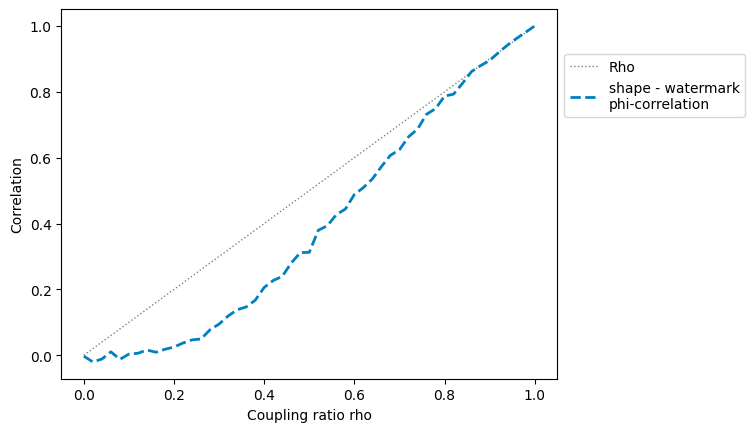

In [106]:
# Ground Truth
biases = list(np.round(np.linspace(0, 1, 51), 3))
with open("m1_mi_6400.pickle", "rb") as f:
    m1_mi = pickle.load(f)
with open("m0_test.pickle", "rb") as f: #gt_measures_1280
    gt_measures = pickle.load(f)
with open("shape_gt_6400.pickle", "rb") as f:
    shape_gt = pickle.load(f)
mimean = torch.mean(m1_mi, dim=1)
print(gt_measures.shape)

""" plt.plot(biases, torch.mean(shape_gt[:,:,0], dim=1),linewidth=2, label="MI shape", color="#f90", alpha=0.5)
plt.plot(biases, gt_measures[:,0,0],linewidth=2, label="MI true label - watermark", linestyle="dashed", color="#f00")
plt.plot(biases, torch.mean(gt_measures[:,:,2], dim=1),linewidth=1, label="MI (distribution rho) true label - watermark", linestyle="dotted", color="#f55")
plt.plot(biases, mimean[:,0],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00") """
ecol = matplotlib.cm.winter(np.linspace(0, 1, 5))
#plt.plot(biases, torch.mean(shape_gt[:,:,1], dim=1),linewidth=2, label="shape - prediction", color=ecol[3])
plt.plot(biases, biases,linewidth=1, label="Rho", linestyle="dotted", color="gray")
plt.plot(biases, torch.mean(gt_measures[:,:,1,1], dim=1),linewidth=2, label="shape - watermark\nphi-correlation", linestyle="dashed", color=ecol[2])
#plt.plot(biases, torch.mean(gt_measures[:,:,3], dim=1),linewidth=1, label="(distribution rho) prediction - watermark", linestyle="dotted", color=ecol[2])
#plt.plot(biases, mimean[:,1],linewidth=2, label="(unbiased data) prediction - watermark", color=ecol[0])

 
plt.ylabel("Correlation")
plt.xlabel("Coupling ratio rho")
plt.legend(bbox_to_anchor=(1., 0.69,0.6, 0.0), loc='lower left',ncols=1, )
#(0., -0.53, 1., .102)

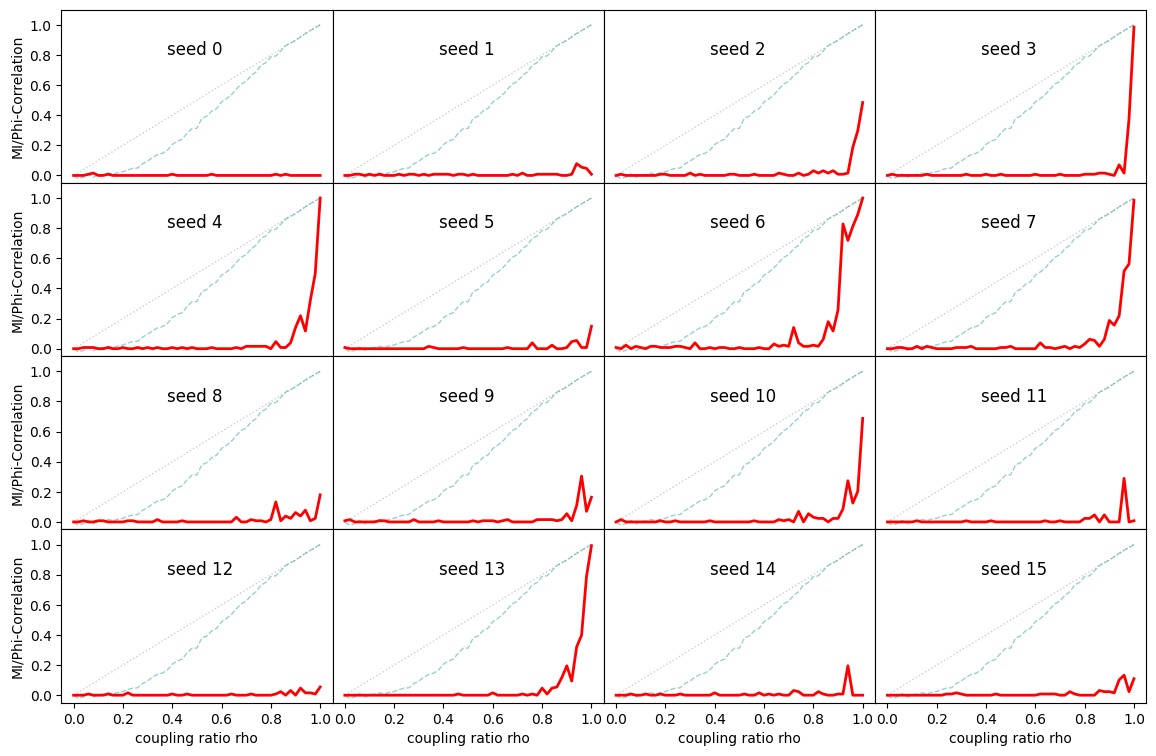

In [109]:
# MI and PHI over seeds

with open("pf_128.pickle", "rb") as f:
    m1_mi = pickle.load(f)
    
biases = list(np.round(np.linspace(0, 1, 51), 3))
fig, axs = plt.subplots(
        4,
        4,
        figsize=(
            14,
            9,
        ),
        gridspec_kw={"wspace": 0.0, "hspace": 0},
    )
for s in range(16):
    axs[s //4, s % 4].set_ylim([-0.05, 1.1])
    axs[s //4, s % 4].set_xlabel("coupling ratio rho")
    axs[s //4, s % 4].set_ylabel("MI/Phi-Correlation")
    if s // 4 != 3 :
        axs[s //4, s % 4].xaxis.set_visible(False)
    if s % 4 != 0:
        axs[s //4, s % 4].yaxis.set_visible(False)
    axs[s //4, s % 4].text(
        0.38, 0.8,
        f"seed {s}",
        size=12,
    )
    axs[s //4, s % 4].plot(biases, biases,linewidth=1, label="Rho", linestyle="dotted", color="gray", alpha=0.4)
    axs[s //4, s % 4].plot(biases, torch.mean(gt_measures[:,:,1,1], dim=1),linewidth=1, label="shape - watermark\nphi-correlation", linestyle="dashed", color="#088", alpha=0.4)
    axs[s //4, s % 4].plot(biases, m1_mi[:,s,0],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00")
    #axs[s //4, s % 4].plot(biases, m1_mi[:,s,1],linewidth=2, label="Phi (data unbiased) prediction - watermark", color="#088")

In [145]:
with open("all_measures_128.pickle", "rb") as f:
    per_sample = pickle.load(f)

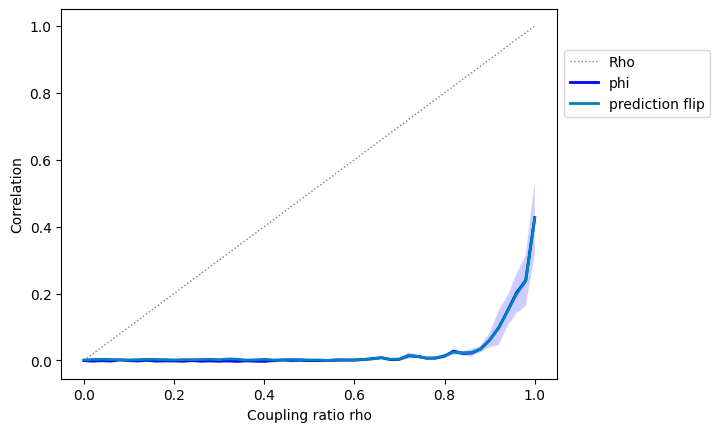

In [92]:
# Phi Correlation VS Prediction Flip
biases = list(np.round(np.linspace(0, 1, 51), 3))
with open("pf_128.pickle", "rb") as f:
    pf_128 = pickle.load(f)

mimean = torch.mean(per_sample[:, :, 0, 4], dim=1)
pf_128_mean = torch.mean(pf_128, dim=1)
plt.plot(biases, biases, linewidth=1, label="Rho", linestyle="dotted", color="gray")
ecol = matplotlib.cm.winter(np.linspace(0, 1, 5))

plt.plot(biases, mimean, linewidth=2, label="phi", color=ecol[0])
sigmaphi = torch.std(per_sample[:, :, 0, 4], dim=1) / math.sqrt(16)
plt.fill_between(
    biases,
    mimean + sigmaphi,
    mimean - sigmaphi,
    facecolor=ecol[0],
    alpha=0.1,
)

plt.plot(biases, pf_128_mean[:, 0], linewidth=2, label="prediction flip", color=ecol[2])
sigmapf = (torch.std(pf_128[:, :, 0], dim=1) / math.sqrt(16))[:, 0]
plt.fill_between(
    biases,
    pf_128_mean[:, 0, 0] + sigmapf,
    pf_128_mean[:, 0, 0] - sigmapf,
    facecolor=ecol[0],
    alpha=0.1,
)
plt.ylabel("Correlation")
plt.xlabel("Coupling ratio rho")
plt.legend(
    bbox_to_anchor=(1.0, 0.69, 0.6, 0.0),
    loc="lower left",
    ncols=1,
)

In [393]:
import gzip

filename = f"outputs/measures/{50}_{4}.gz"
with gzip.open(filename, mode="rb") as f:
    r_m_info = pickle.load(f)
pred0s = r_m_info[1][:, 0].to(dtype=torch.float)
pred1s = r_m_info[1][:, 1].to(dtype=torch.float)
maxval = max(pred0s.abs().max(), pred1s.abs().max())
pred0sabbs = pred0s / maxval
pred1sabs = pred1s / maxval
print(
    torch.mean(torch.sum(torch.abs(pred1s - pred0s), dim=1) / (4*maxval)),
    torch.mean(torch.sum(torch.abs(pred1sabs - pred0sabbs), dim=1) / 4),
    torch.sum(torch.abs(pred1s - pred0s) / (128 * 4 * maxval)),
    ms.euclidean_distance(pred1s, pred0s) / (256),
    ms.euclidean_distance(pred1sabs, pred0sabbs) / 32,
    torch.mean(torch.sqrt(torch.sum(((pred1sabs - pred0sabbs)**2), dim=1))/ np.sqrt(8)) ,
    torch.mean((1
            - torch.nn.functional.cosine_similarity(
                pred1sabs,
                pred0sabbs,
                dim=1,
            ))/2)
)

tensor(0.3856) tensor(0.3856) tensor(0.3856) 0.5482499003410339 0.3981616497039795 tensor(0.3862) tensor(0.9994)


In [451]:
tst1 = torch.zeros((128, 8,64,64)) #torch.ones(128,8,64,64)#
tst2 = torch.zeros((128, 8,64,64)) #-1*torch.ones(128,8,64,64)#
tst1[:,:,:9,4:6] = 1
print(tst1[0,0].sum())
#tst2[:, 0] = -1
#tst2[:, 1] = 1
#tst1_norm = tst1 / torch.linalg.vector_norm(tst1)
#tst2_norm = tst2 / torch.linalg.vector_norm(tst2)
print(
    ms.euclidean_distance(tst1, tst2) ,#/ 4096,
    torch.mean((1
            - torch.nn.functional.cosine_similarity(
                tst1,
                tst2,
                dim=0,
            ))/2),
    torch.mean(torch.sum(torch.abs(tst1 - tst2), dim=(2,3))/18)  , #/ (4096*8*2)
    torch.mean(torch.sqrt(torch.sum(((tst1 - tst2)**2), dim=(2,3)))/np.sqrt(18)), #/ (np.sqrt(131072))
    #torch.sqrt(torch.sum(((tst1 - tst2)**2), dim=(2,3))),
    #np.sqrt(18)
)

tensor(18.)
135.76449584960938 tensor(0.5000) tensor(1.) tensor(1.)


In [220]:

#ms.cosine_distance(hm1s, hm0s)
hm0s = r_m_info[0][:, 0].to(dtype=torch.float)
hm1s = r_m_info[0][:, 1].to(dtype=torch.float)
torch.mean(torch.sum( torch.abs(hm1s- hm0s), dim=(1,2,3) ) / 36 )
#sum([ms.euclidean_distance(hm1s[i], hm0s[i]) for i in range(128)]) / 128, ms.euclidean_distance(hm1s, hm0s) / 8

tensor(0.0099)

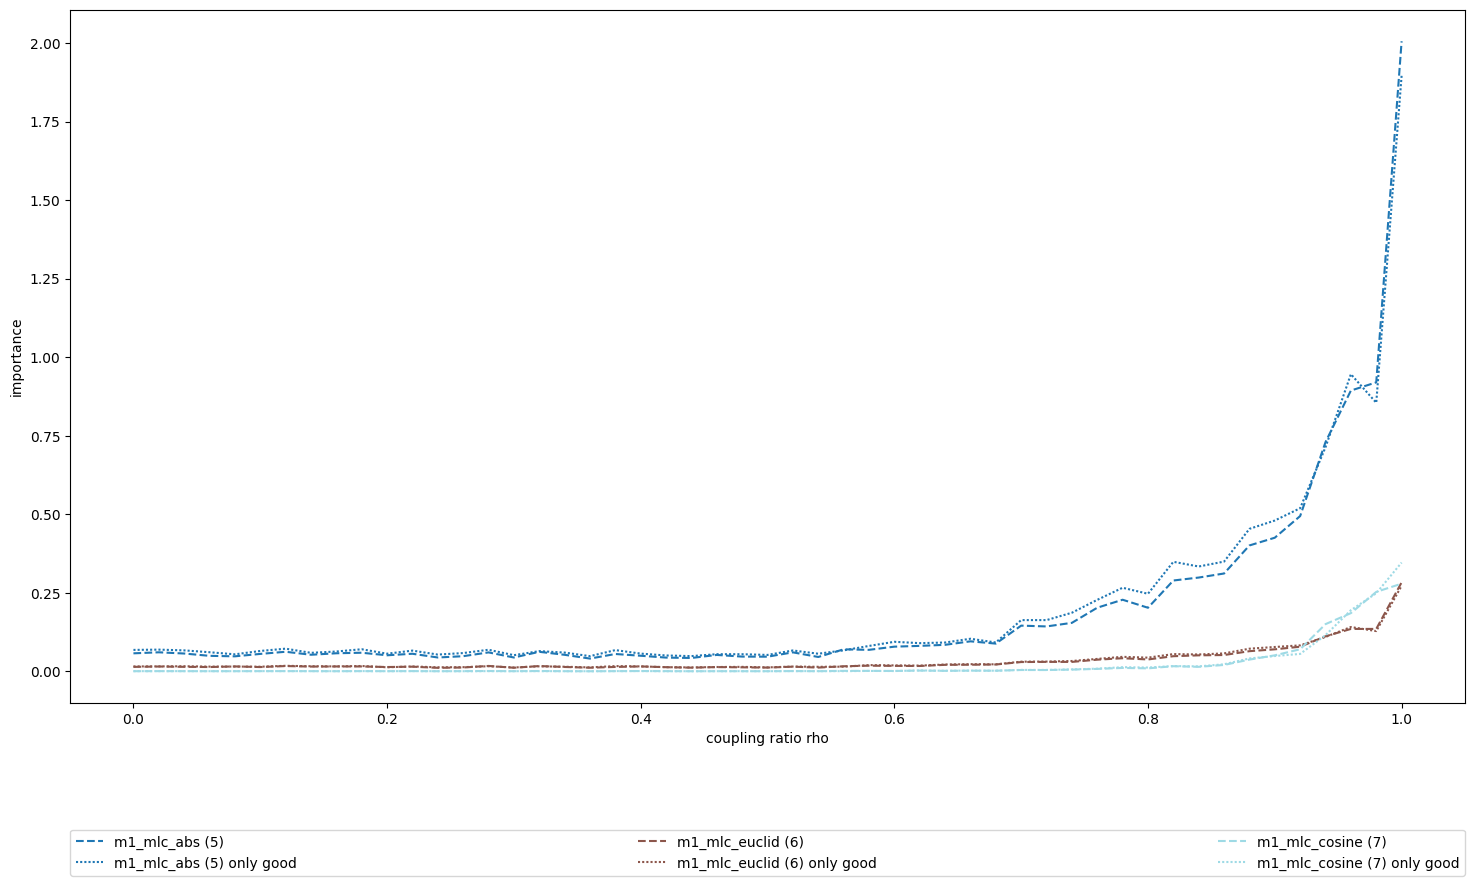

In [146]:
# FILTER BAD OUT
def filter_bad_out(data):
    filtered = torch.zeros(51,12,128,22)
    c = 0
    for num_it in range(16):
        if num_it not in [6,14, 1,3,]: #1,3,
            filtered[:, c] = data[:,num_it,:,:]
            c+=1
    return filtered
normalized = per_sample
normalized[:,:,:,5] = normalized[:,:,:,5]  / 512#torch.max(per_sample[:,:,:,5], dim=2).values.view(51,16,1)
filtered = filter_bad_out(normalized)

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = [5,6,7] #range(len(ALL_MEASURES))
ls = ["dotted", "dashed", "solid"]
per_rho = torch.mean(normalized, dim=(1,2))
per_rho_good = torch.mean(filtered, dim=(1,2))
#normalized = per_rho / torch.max(per_rho, dim=0).values

colors = matplotlib.cm.tab20(np.linspace(0, 1, len(takeing)))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    #for s in range(16):
    l = ALL_MEASURES[i]
    label = f"{l} ({i})" #if s == 0 else ""
    vals = per_rho[:,i] / enums[i][2] #normalized[:,i],
    vals_good = per_rho_good[:,i] / enums[i][2] #normalized[:,i],

    if  l: #.startswith("m2_mac") #"bbox" in l or "kernel" in
        plt.plot(
            biases,
            vals,
            label=label,
            linestyle=ls[int(l[1])],
            c=colors[en],
        )  
        plt.plot(
            biases,
            vals_good,
            label=f"{label} only good",
            linestyle=(0, (1, 1)),
            c=colors[en],
        ) 

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


tensor([0.0029, 0.0041, 0.0028, 0.0043, 0.0034, 0.0038, 0.0031, 0.0036, 0.0042,
        0.0037, 0.0022, 0.0035, 0.0034, 0.0032, 0.0050, 0.0024, 0.0040, 0.0025,
        0.0030, 0.0031, 0.0047, 0.0025, 0.0048, 0.0020, 0.0066, 0.0033, 0.0065,
        0.0053, 0.0033, 0.0047, 0.0064, 0.0064, 0.0075, 0.0050, 0.0050, 0.0075,
        0.0138, 0.0107, 0.0126, 0.0150, 0.0095, 0.0141, 0.0208, 0.0169, 0.0201,
        0.0232, 0.0307, 0.0392, 0.0509, 0.0638, 0.0911])


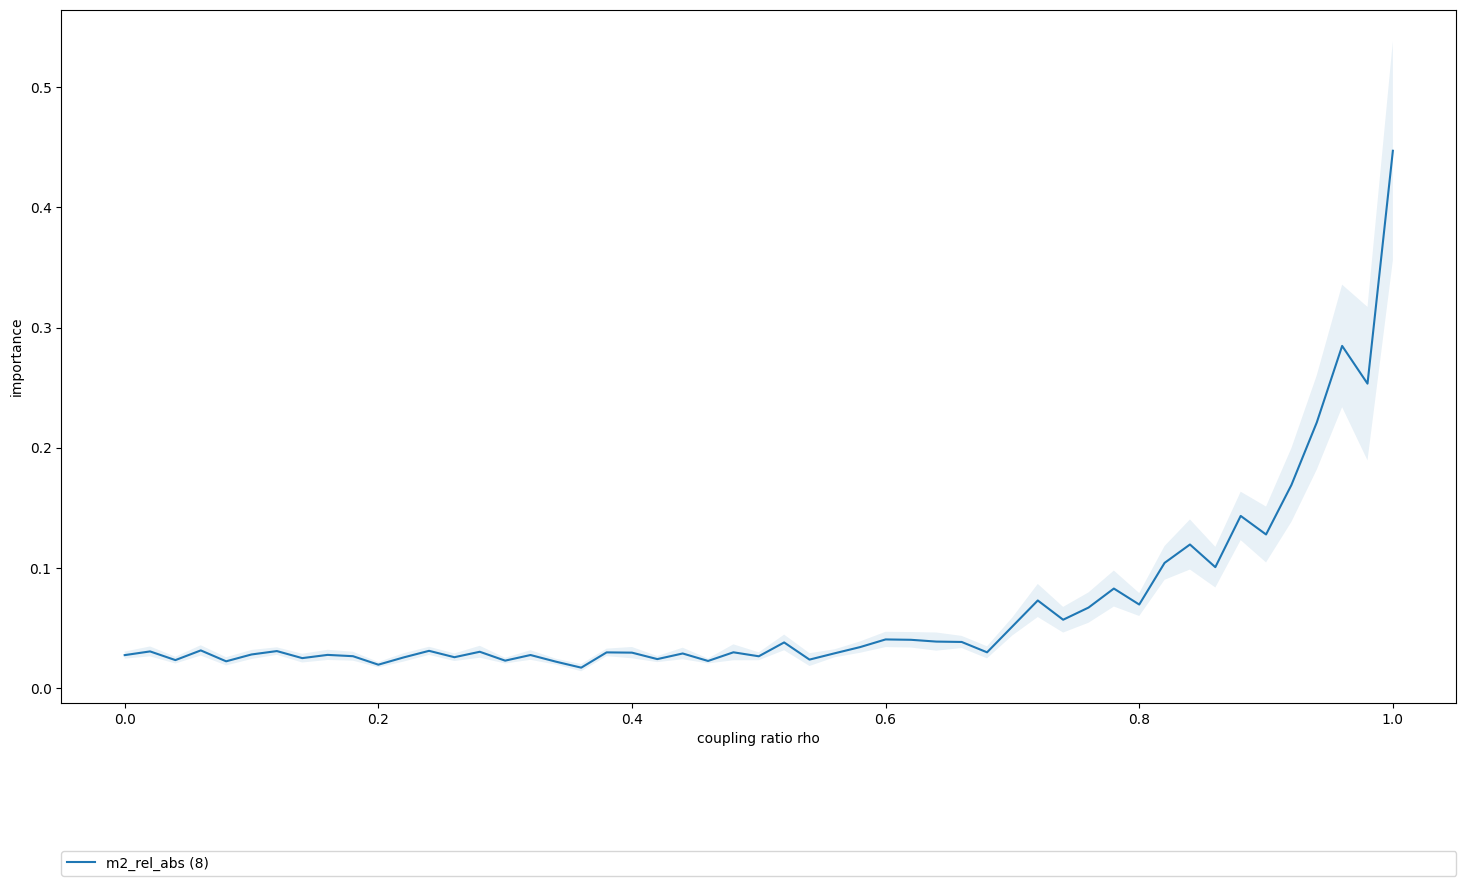

In [281]:
# SHOW CERTAIN MEASURES

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = [8] #range(len(ALL_MEASURES))
ls = ["dotted", "dashed", "solid"]
per_seed = torch.mean(filtered, dim=2) #per_sample
normalization = torch.tensor([a[2] for a in enums])
per_seed = per_seed / normalization

colors = matplotlib.cm.tab10(np.linspace(0, 1, len(takeing)))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    #for s in range(16):
    l = ALL_MEASURES[i]
    label = f"{l} ({i})" #if s == 0 else ""
    vals = torch.mean(per_seed[:,:,i], dim=1) #normalized[:,i],
    sigma = torch.std(per_seed[:,:,i],dim=1) / math.sqrt(16)
    vmin = torch.min(per_seed[:,:,i],dim=1).values
    vmax = torch.max(per_seed[:,:,i],dim=1).values
    print(sigma)
    if  l: #.startswith("m2_mac") #"bbox" in l or "kernel" in
        plt.plot(
            biases,
            vals,
            label=label,
            linestyle=ls[int(l[1])],
            c=colors[en],
        ) 
        
        plt.fill_between(
            biases,
            vals + sigma,
            vals - sigma,
            facecolor=colors[en],
            alpha=0.1,
        ) 

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


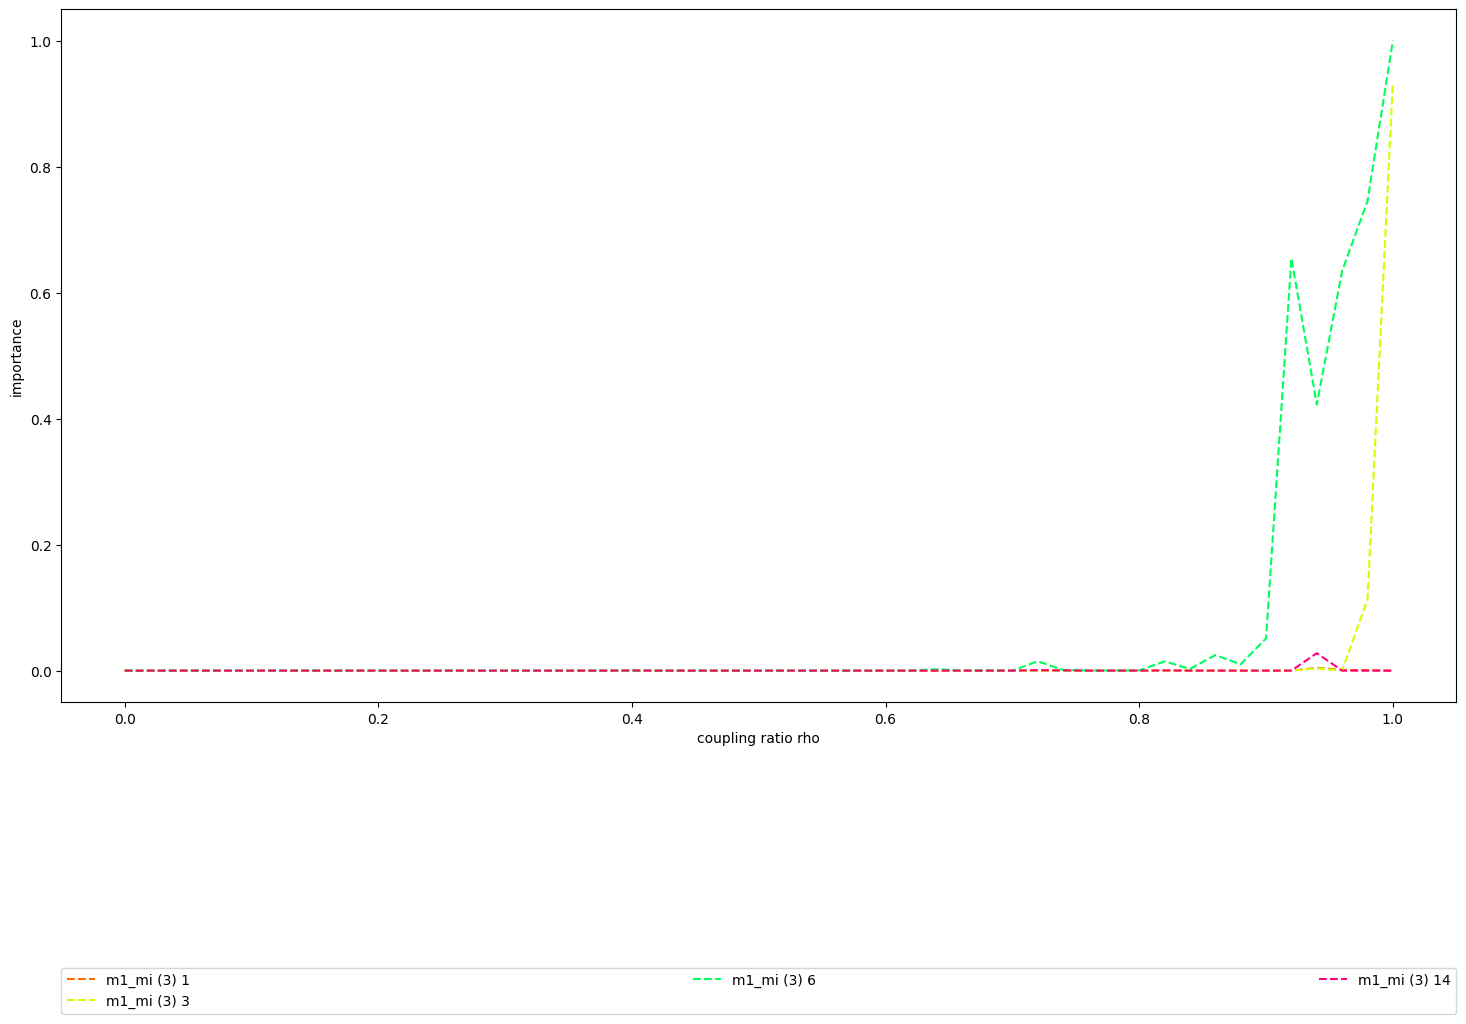

In [207]:
# MEASURES OVER SINGLE SEEDS

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = [3]#,12,16,18, 20] #range(len(ALL_MEASURES))
ls = ["dotted", "dashed", "solid"]
per_rho = torch.mean(per_sample, dim=(2))

#colors = matplotlib.cm.tab20(np.linspace(0, 1, len(takeing)))
colors = matplotlib.cm.hsv(np.linspace(0, 1, 16))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    for num in [1,3,6,14]:
        l = ALL_MEASURES[i]
        label = f"{l} ({i}) {num}"
        vals = per_rho[:,num, i] / enums[i][2] 
        if  l: #.startswith("m2_mac")
            plt.plot(
                biases,
                vals,
                label=label,
                linestyle=ls[int(l[1])],
                c=colors[num],
            )  

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.45, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


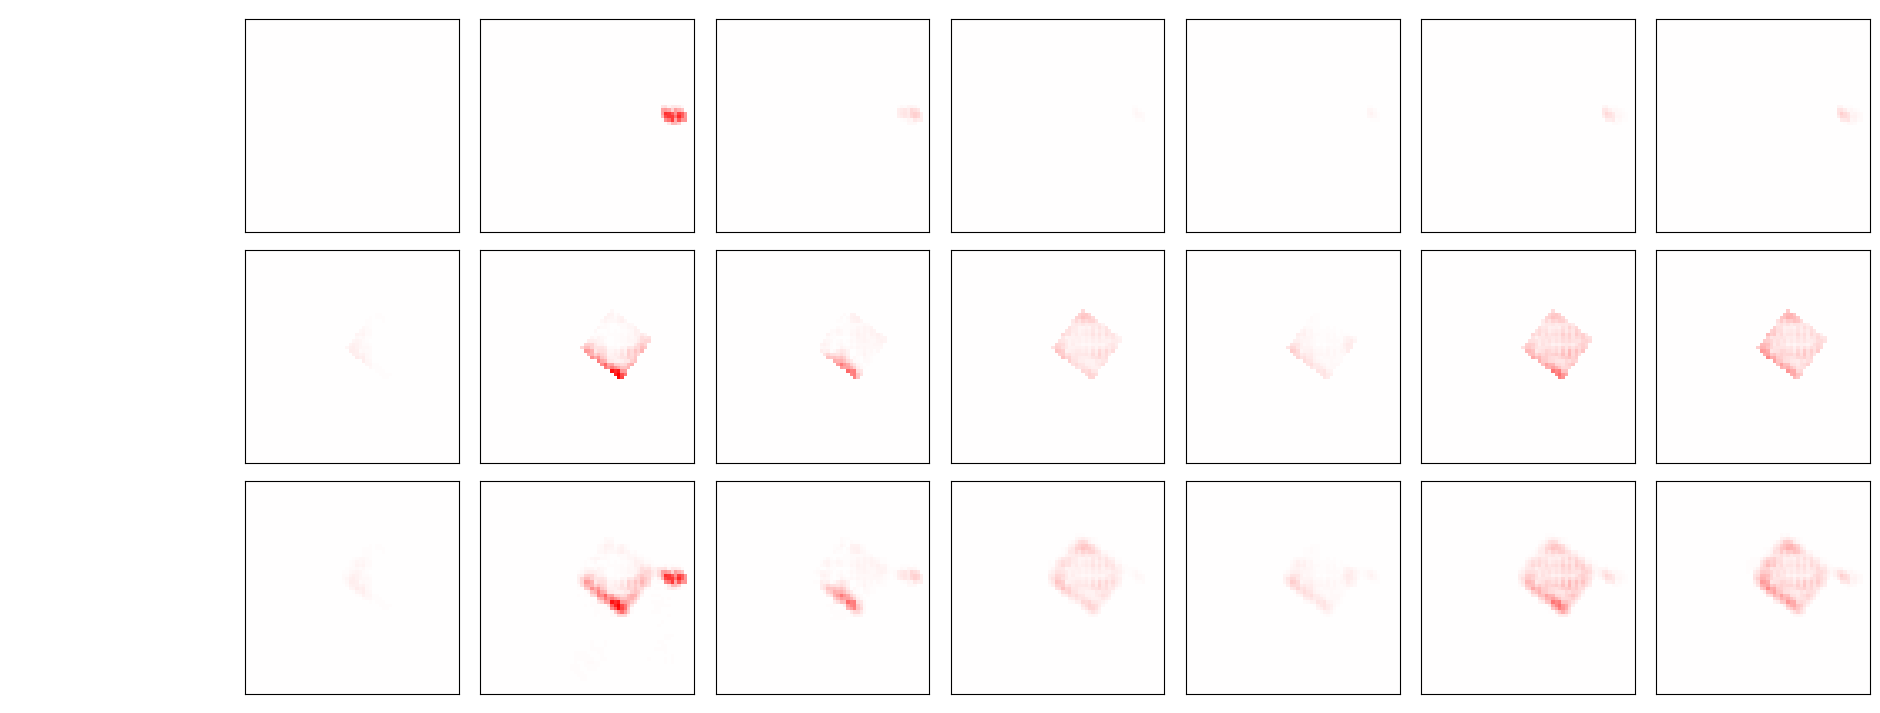

In [92]:
from measures0_to_2 import AllMeasures

bias = 1.0
num_it = 2
name = to_name(bias, num_it)
NAME = "../clustermodels/final"
ms = AllMeasures("../dsprites-dataset/images/", 5)
layer_name = "convolutional_layers.6"
index = 159500
model = load_model(NAME, bias, num_it)
crpa = CRPAttribution(model, ms.ds, "test", name)

image = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

lat, _, offset = ms.ds.get_item_info(index)

wm_mask = torch.zeros(64, 64)
wm_mask[
    max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
    max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
] = 1
shape_mask = ms.ds.load_shape_mask(index)
nlen = 8
conditions = [{layer_name: [i]} for i in crpa.layer_id_map[layer_name]]
res = 0.0

images = torch.zeros(3, nlen, 64, 64)
for attr in crpa.attribution.generate(
    image,
    conditions,
    crpa.composite,
    start_layer="linear_layers.2",
    record_layer=crpa.layer_names,
    verbose=False,
    batch_size=nlen,
):
    heatmaps_abs = attr.heatmap.abs()
    total_rel = torch.sum(heatmaps_abs, dim=(1, 2))
    images[0, :, :, :] = heatmaps_abs * wm_mask
    images[1, :, :, :] = heatmaps_abs * shape_mask[0]
    images[2, :, :, :] = heatmaps_abs
    wm_rel = torch.sum(heatmaps_abs * wm_mask, dim=(1, 2))
    shape_rel = torch.sum(heatmaps_abs * shape_mask[0], dim=(1, 2))
    vals = torch.zeros(nlen)
    for i in range(nlen):
        if wm_rel[i] > (shape_rel[i] * (wm_mask.sum() / (shape_mask.sum()))):
            vals[i] = wm_rel[i]
        else:
            vals[i] = 0
images = images.detach()
my_plot_grid(images, 3, nlen, resize=3, norm=True)

In [93]:
image1 = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

diff_heatmaps = torch.zeros(2, nlen, 64, 64)
hm1 = ms.heatmaps(image1, crpa)
hm0 = ms.heatmaps(image0, crpa)

predv_0 = model(image0)
predv_1 = model(image1)

diff_heatmaps[0, :, :, :] = hm1
diff_heatmaps[1, :, :, :] = hm0
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)
def kernel(a,b):
    return torch.nn.functional.conv2d(a, a) - 2*torch.nn.functional.conv2d(a, b) + torch.nn.functional.conv2d(b, b) 
def kernel1d(a,b):
    return torch.nn.functional.conv1d(a, a) - 2*torch.nn.functional.conv1d(a, b) + torch.nn.functional.conv1d(b, b) 

truediff = kernel(wm_mask.view(1,1,64,64), shape_mask.view(1,1,64,64)) 
diffs = []
predv_0, predv_1 = predv_0 / 6.1175, predv_1 / 6.1175
print(predv_0 , predv_1 ,kernel1d(predv_0.view(1,1,2),predv_1.view(1,1,2)), ms.euclidean_distance(predv_1, predv_0))
batched = kernel(hm1.view(nlen,1,64,64), hm0.view(nlen,1,64,64))
#print(float(truediff), [float(batched[i,i].flatten()) for i in range(8)], sum([float(batched[i,i].flatten()) for i in range(8)]))
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)


tensor([[ 0.6487, -0.1161]], grad_fn=<DivBackward0>) tensor([[-0.4496,  0.8052]], grad_fn=<DivBackward0>) tensor([[[2.0548]]], grad_fn=<AddBackward0>) 1.4334536790847778


tensor(0.1410)


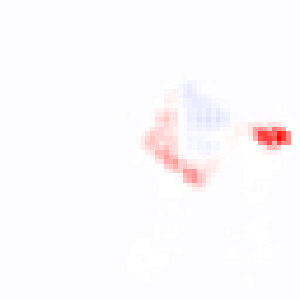

In [94]:
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient


data = torch.randn(1, 3, 224, 224)
input_img = image1
composite = EpsilonPlusFlat()

with composite.context(model) as modified_model:
    output = modified_model(input_img)
    # gradient/ relevance wrt. class/output 0tensor(0.1172)
￼
tensor(3.7253e-09)
￼
' print(list(enumerate(ALL_MEASURES)))\nbiases = list(np.round(np.linspace(0, 1, 51), 3)) '
<matplotlib.legend.Legend at 0x7f80a3e564d0>
￼
￼
torch.Size([51, 16, 128, 22]) torch.Size([51, 22])
torch.Size([51, 22])
<matplotlib.legend.Legend at 0x7f8099b1bdc0>
￼
￼
    output.backward(gradient=torch.eye(2)[[1]])
vmax = input_img.grad.max()
print(vmax)
imgify(input_img.grad[0, 0], vmax=vmax, vmin=-vmax, resize=300)

tensor(0.1172)


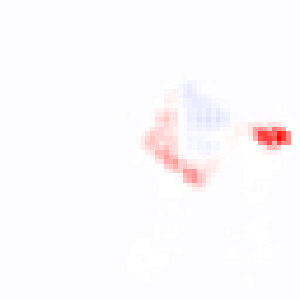

In [95]:
summed_hms = torch.sum(hm1 , dim=0)
vmaxhm = summed_hms.max()
print(vmaxhm)
imgify(summed_hms, vmax=vmaxhm, vmin=-vmaxhm, resize=300)

tensor(3.7253e-09)


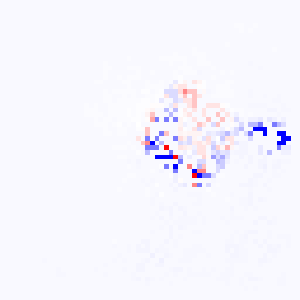

In [97]:
res = summed_hms * (vmax / vmaxhm) - input_img.grad[0, 0]
resmax = res.max()
print(resmax)
imgify(res, vmax=resmax, vmin=-resmax, resize=300)

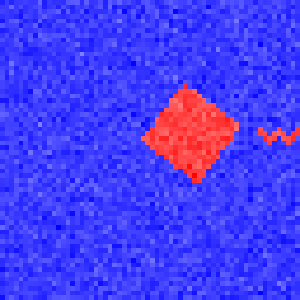

In [107]:
imgify(image1[0,0],resize=300)

In [272]:
bs = BiasedNoisyDataset()
len(bs.labels)

737280

In [274]:
737280 // 3

245760